In [7]:
def diffusive(scale,ndim,time,epsilon=1e-7):
        
    mus1 = np.zeros((ndim))
    rho1 = np.random.random(1+(ndim-2)*2) + epsilon
    sigmas1 = scale*np.random.random(1) + epsilon


    cov = sigmas1 * np.eye(ndim) + epsilon
    
    return np.cumsum(numpy.random.multivariate_normal(mus1,cov,time),axis=0)


In [13]:
from Tools import generate_traj,random_rot,traj_to_dist
from scitool.propertie import Propertie

def add_miss_tracking(traj,N,f=10):
    
    step = traj[1:]-traj[:-1]
    
    std = np.average(np.sum(step**2,axis=1)**0.5)
    
    for i in range(N):
        w = np.random.randint(0,len(traj))
        traj[w] = np.random.normal(traj[w],f*std)
    
    return traj


def generate_N_nstep(N,nstep,ndim=2,sub=False):
    add = 0
    if ndim == 3:
        add = 1
    size = nstep
    
    X_train = np.zeros((N,size,(5+add)))
    Y_trains = np.zeros((N,size,10))
    Y_train_cat = np.zeros((N,1,27))
    Y_train_traj = []

    #12
    for i in range(N):
    #for i in range(1000):

        #if i % 1000 == 0:
        #    print i
        sigma = max(np.random.normal(0.5,1),0.05)
        step = max(np.random.normal(1,1),0.2)
        tryagain = True
        while tryagain:
            try:

         
                clean = 4
                if size >=50:
                    clean = 8
                    
                clean = False
                """
                ModelN,Model_num,s,sc,real_traj,norm,Z = generate_traj(size,sub=True,
                                                                       clean=clean,diff_sigma=2.0,
                                                                       delta_sigma_directed=1.,ndim=ndim,
                                                                      anisentropy=0.1,deltav=0.2,rho_fixed=False)
                """
                clean=10
                
                
                
                real_traj = diffusive(1,2,size+1)
                
                real_traj[:10] *= 2
                real_traj[-10:] *= 2
                ModelN = 2
                Model_num = 2
                sc = [0] * size
                s = sc
                Z = []
                
                
                mu=2
                Ra0 = [0,1.]
             
                
                alpharot = 2*3.14*np.random.random()
                
                dt = real_traj[1:]-real_traj[:-1]
                std = np.mean(np.sum(dt**2,axis=1)/3)**0.5
                
                
                noise_level = .25*np.random.rand()
                real_traj += np.random.normal(0,noise_level*std,real_traj.shape)
                
                real_traj  = random_rot(real_traj,alpharot,ndim=ndim)
                

                
                #print real_traj.shape
                alligned_traj,normed,alpha,_ = traj_to_dist(real_traj,ndim=ndim)
                simple=True
                if not simple:
                    real_traj1 = np.array([Propertie(real_traj[::,0]).smooth(2),
                                           Propertie(real_traj[::,1]).smooth(2)])
                    alligned_traj1,normed1,alpha1,_ = traj_to_dist(real_traj1.T,ndim=ndim)
                    real_traj2 = np.array([Propertie(real_traj[::,0]).smooth(5),
                                           Propertie(real_traj[::,1]).smooth(5)])
                    alligned_traj2,normed2,alpha2,_ = traj_to_dist(real_traj2.T,ndim=ndim)

                    normed = np.concatenate((normed[::,:4],normed1[::,:4],normed2),axis=1)

                for zero in Z:
                    normed[zero,::] = 0
            
                tryagain=False
                
                
            except IndexError:
                tryagain=True
                
        Y_train_traj.append(real_traj)
        X_train[i] = normed
      
        Y_trains[i][range(size),np.array(sc,dtype=np.int)] = 1
     
        Y_train_cat[i,0,Model_num] = 1
        
    
    return X_train,Y_trains,Y_train_cat,Y_train_traj

Normed = generate_N_nstep(1000,100)[0]

In [44]:
Normed = generate_N_nstep(1000,200)[0]

In [45]:
from Specialist_layer import return_layer_paper

graph = return_layer_paper(n_layers=4,simple=False,inputsize=5)
graph_simplo = return_layer_paper(n_layers=4,simple=True,inputsize=5)

graph_simplo.load_weights("weight-folder/4layer-LSTM-simple_7_140")
graph.load_weights("/home/jarbona/cluster_theano/weight-folder/4layer-LSTM_7_140")

In [46]:
p = graph.predict({"input1":np.array([t for t in Normed])},batch_size=50)
ps = graph_simplo.predict({"input1":np.array([t for t in Normed])},batch_size=50)

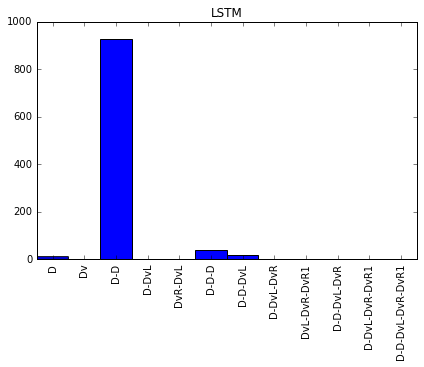

In [47]:
title("LSTM")
hist(np.argmax(p["category"],axis=-1),range=[-0.5,11.5],bins=12)
xlim(-0.5,11.5)
t = xticks(np.arange(0,12,1),M0,rotation=90)

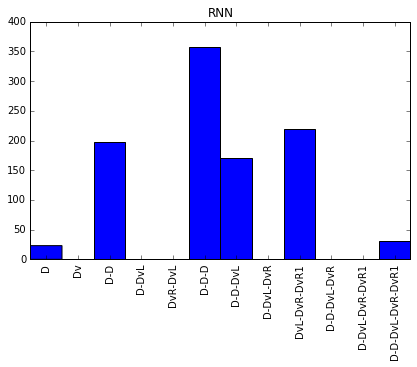

In [48]:
from Tools import M0
title("RNN")
hist(np.argmax(ps["category"],axis=-1),range=[-0.5,11.5],bins=12)
xlim(-0.5,11.5)
t = xticks(np.arange(0,12,1),M0,rotation=90)